In [1]:
import os
import pandas as pd
from matplotlib import pyplot as plt
import cv2
import numpy as np

#data path 수정
os.chdir("C:\\Users\\Owner2\\Desktop\\G팔로미_vuno")
os.getcwd()

'C:\\Users\\Owner2\\Desktop\\G팔로미_vuno'

In [2]:
X=np.load('data_X_with_callback.npy')
y=np.load('data_y_with_callback.npy')

In [3]:
len(X)

2145

In [4]:
#train, validation set 분리
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.2, random_state=123)

In [5]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    #featurewise_center=True, #center 중심 유지
    #featurewise_std_normalization=True, #normalization
    rotation_range=25.0,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.2,1.0],
    zoom_range=[0.8,1.2],
    horizontal_flip=True) #수평방향 뒤집기

datagen.fit(X_train)

dgf=datagen.flow(X_train,y_train,batch_size=32)

Using TensorFlow backend.


In [6]:
from keras import models, layers
from keras import Input
from keras.applications import VGG16
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import BatchNormalization, Conv2D, Activation, Dense, GlobalAveragePooling2D, MaxPooling2D, ZeroPadding2D, Add

model = VGG16(weights=None, include_top=False, input_shape=(224, 224, 3))
model.trainable = True
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [7]:
#customizing my layers
additional_model = models.Sequential()
additional_model.add(model)
additional_model.add(layers.Flatten())
additional_model.add(layers.Dense(4, activation='softmax'))

additional_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 100356    
Total params: 14,815,044
Trainable params: 14,815,044
Non-trainable params: 0
_________________________________________________________________


In [8]:
def f1score(precision, recall):
    _f1score = ( 2 * recall * precision) / (recall + precision)
    
    # return a single tensor value
    return _f1score

In [9]:
# checkpoint = ModelCheckpoint(filepath='My_VGG_{epoch:03d}_{val_loss:.7f}.hdf5',monitor='loss', mode='min', save_best_only=True)
checkpoint = ModelCheckpoint(filepath='VGG16_2(augment).hdf5', 
            monitor='val_loss', 
            mode='min', 
            save_best_only=True)

In [10]:
import tensorflow as tf

additional_model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc',tf.keras.metrics.AUC(),
                      tf.keras.metrics.Precision(),
                      tf.keras.metrics.Recall(),f1score])

In [11]:
history = additional_model.fit_generator(dgf, 
            steps_per_epoch=len(X_train)/32, 
            epochs=100, 
            validation_data=(X_val,y_val), 
            validation_steps=len(X_val)/32, 
            callbacks=[checkpoint])

Epoch 1/100
54/53 [==============================] - 23s 432ms/step - loss: 1.3801 - acc: 0.3438 - auc: 0.5533 - precision: 0.2765 - recall: 0.0125 - f1score: 0.1027 - val_loss: 1.3845 - val_acc: 0.3240 - val_auc: 0.5704 - val_precision: 0.3824 - val_recall: 0.0134 - val_f1score: 0.1002
Epoch 2/100
54/53 [==============================] - 17s 312ms/step - loss: 1.3431 - acc: 0.3893 - auc: 0.5828 - precision: 0.3921 - recall: 0.0122 - f1score: 0.1055 - val_loss: 1.3812 - val_acc: 0.3240 - val_auc: 0.5920 - val_precision: 0.4122 - val_recall: 0.0132 - val_f1score: 0.1004
Epoch 3/100
54/53 [==============================] - 18s 326ms/step - loss: 1.2980 - acc: 0.4167 - auc: 0.6071 - precision: 0.4465 - recall: 0.0215 - f1score: 0.1109 - val_loss: 1.3794 - val_acc: 0.3240 - val_auc: 0.6134 - val_precision: 0.4562 - val_recall: 0.0242 - val_f1score: 0.1006
Epoch 4/100
54/53 [==============================] - 18s 326ms/step - loss: 1.3172 - acc: 0.4044 - auc: 0.6166 - precision: 0.4760 - rec

54/53 [==============================] - 18s 330ms/step - loss: 1.0694 - acc: 0.5076 - auc: 0.7028 - precision: 0.6086 - recall: 0.1249 - f1score: 0.1368 - val_loss: 1.2682 - val_acc: 0.3963 - val_auc: 0.7042 - val_precision: 0.6099 - val_recall: 0.1266 - val_f1score: 0.1118
Epoch 30/100
54/53 [==============================] - 18s 327ms/step - loss: 1.0803 - acc: 0.5122 - auc: 0.7054 - precision: 0.6110 - recall: 0.1282 - f1score: 0.1359 - val_loss: 1.3241 - val_acc: 0.3124 - val_auc: 0.7065 - val_precision: 0.6127 - val_recall: 0.1298 - val_f1score: 0.1065
Epoch 31/100
54/53 [==============================] - 18s 332ms/step - loss: 1.0407 - acc: 0.5052 - auc: 0.7078 - precision: 0.6141 - recall: 0.1315 - f1score: 0.1396 - val_loss: 1.2710 - val_acc: 0.3613 - val_auc: 0.7091 - val_precision: 0.6146 - val_recall: 0.1331 - val_f1score: 0.1126
Epoch 32/100
54/53 [==============================] - 18s 330ms/step - loss: 1.0345 - acc: 0.5274 - auc: 0.7106 - precision: 0.6163 - recall: 0.13

54/53 [==============================] - 18s 333ms/step - loss: 0.9302 - acc: 0.5624 - auc: 0.7508 - precision: 0.6267 - recall: 0.2124 - f1score: 0.1510 - val_loss: 1.3525 - val_acc: 0.3706 - val_auc: 0.7513 - val_precision: 0.6269 - val_recall: 0.2135 - val_f1score: 0.1129
Epoch 58/100
54/53 [==============================] - 18s 333ms/step - loss: 0.9009 - acc: 0.5699 - auc: 0.7521 - precision: 0.6272 - recall: 0.2148 - f1score: 0.1541 - val_loss: 1.4297 - val_acc: 0.3403 - val_auc: 0.7526 - val_precision: 0.6271 - val_recall: 0.2161 - val_f1score: 0.1111
Epoch 59/100
54/53 [==============================] - 18s 332ms/step - loss: 0.9440 - acc: 0.5571 - auc: 0.7532 - precision: 0.6270 - recall: 0.2172 - f1score: 0.1501 - val_loss: 1.5416 - val_acc: 0.3380 - val_auc: 0.7536 - val_precision: 0.6270 - val_recall: 0.2184 - val_f1score: 0.1082
Epoch 60/100
54/53 [==============================] - 18s 332ms/step - loss: 0.9140 - acc: 0.5862 - auc: 0.7541 - precision: 0.6275 - recall: 0.21

54/53 [==============================] - 18s 330ms/step - loss: 0.8142 - acc: 0.6142 - auc: 0.7764 - precision: 0.6280 - recall: 0.2783 - f1score: 0.1624 - val_loss: 1.7933 - val_acc: 0.3147 - val_auc: 0.7767 - val_precision: 0.6279 - val_recall: 0.2793 - val_f1score: 0.1049
Epoch 86/100
54/53 [==============================] - 18s 332ms/step - loss: 0.8136 - acc: 0.6340 - auc: 0.7771 - precision: 0.6281 - recall: 0.2805 - f1score: 0.1639 - val_loss: 1.5602 - val_acc: 0.3497 - val_auc: 0.7775 - val_precision: 0.6283 - val_recall: 0.2815 - val_f1score: 0.1103
Epoch 87/100
54/53 [==============================] - 18s 331ms/step - loss: 0.8241 - acc: 0.6136 - auc: 0.7778 - precision: 0.6284 - recall: 0.2824 - f1score: 0.1616 - val_loss: 1.8650 - val_acc: 0.3520 - val_auc: 0.7781 - val_precision: 0.6283 - val_recall: 0.2833 - val_f1score: 0.1055
Epoch 88/100
54/53 [==============================] - 18s 331ms/step - loss: 0.7946 - acc: 0.6224 - auc: 0.7785 - precision: 0.6283 - recall: 0.28

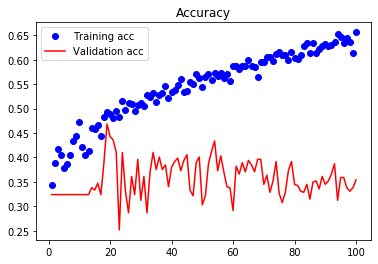

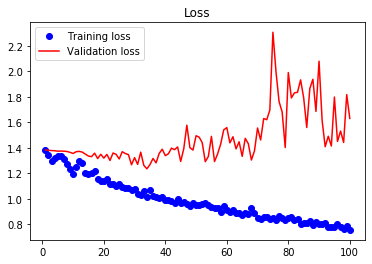

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()
 
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [13]:
_loss, _acc, _auc, _precision, _recall, _f1score = additional_model.evaluate(X_val, y_val, batch_size=32)
print('loss: {:.3f}, accuracy: {:.3f}, auc: {:.3f}, precision: {:.3f}, recall: {:.3f}, f1score: {:.3f}'.format(_loss, _acc, _auc, _precision, _recall, _f1score))

429/429 [==============================] - 1s 3ms/step
loss: 1.631, accuracy: 0.354, auc: 0.787, precision: 0.630, recall: 0.308, f1score: 0.109
